# Repacking with MCMC Sampling

In [1]:
import chilife as xl
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(100)
plt.style.use('chiLife')
plt.rcParams.update({'font.size':15})

C:\Program Files\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mbp = xl.fetch('1omp')
SL1 = xl.SpinLabel('R1M', 124, mbp)
SL2 = xl.SpinLabel('R1M', 281, mbp)

traj, dE = xl.repack(mbp, SL1, SL2,
                     repetitions=10000, temp=298,
                     off_rotamer=True,
                     repack_radius=10)

SL1_repack = xl.SpinLabel.from_trajectory(traj, 124, burn_in=5000, spin_atoms=SL1.spin_atoms)
SL2_repack = xl.SpinLabel.from_trajectory(traj, 281, burn_in=5000, spin_atoms=SL2.spin_atoms)


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [01:15<00:00, 133.11it/s]


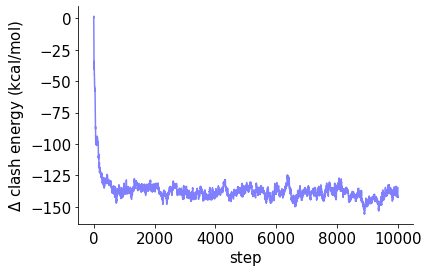

In [3]:
fig, ax = plt.subplots()
ax.plot(np.cumsum(dE))
ax.set_xlabel('step')
ax.set_ylabel(r'$\rm\Delta$ clash energy (kcal/mol)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

fig.savefig('trajectoty.png', bbox_inches='tight', dpi=600)

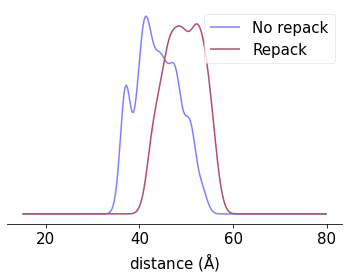

In [4]:
r = np.linspace(15, 80, 256)
P = xl.distance_distribution(SL1, SL2, r)
P_repack = xl.distance_distribution(SL1_repack, SL2_repack, r)

fig, ax = plt.subplots()

ax.plot(r, P, label='No repack')
ax.plot(r, P_repack, label='Repack')
ax.set_xlabel(r'distance ($\rm \AA$)')
ax.set_yticks([])

ax.legend()
for spine in ['left', 'right', 'top']:
    ax.spines[spine].set_visible(False)
plt.show()
fig.savefig('Distance_distributions.png', dpi=600, bbox_inches='tight')

In [5]:

resis = [res.resnum for res in mbp.select_atoms('(not resname ALA GLY HOH) and around 14 resnum 124').residues] + \
        [res.resnum for res in mbp.select_atoms('(not resname ALA GLY HOH) and around 14 resnum 281').residues]

neighbors = [xl.RotamerEnsemble.from_trajectory(traj, resi, burn_in=5000) for resi in resis]
neighbors = [resi for resi in neighbors if len(resi) > 1]


In [6]:
xl.save('N124R1_E281R1.pdb', SL1, SL2, mbp, KDE=False)
xl.save('N124R1_E281R1_repack.pdb', SL1_repack, SL2_repack, *neighbors, mbp, KDE=False)